# How to compose a timing model component

## Building the timing model component from scratch

This example notebook includes the following contents
* Defining a timing model component class
  * Necessary parts
  * Conventions
* Use it with the `TimingModel` class
  * Add the new component to the `TimingModel` class
  * Use the functions in the `TimingModel` class to interact with the new component.
  
We will build a simple model component, pulsar spindow model with spin period as parameters, instead of spin frequency. 

## Import the necessary modules

In [1]:
import numpy as np   # Numpy is a widely used package
# PINT uses astropy units in the internal cacluation and is highly recommended for a new component
import astropy.units as u  
# Import the component classes. 
from pint.models.timing_model import TimingModel, Component, PhaseComponent
import pint.models.parameter as p 

## Define the timing model class

A timing model component should be an inheritance/subclass of `pint.models.timing_model.Component`. PINT also pre-defines three component subclasses for the most used type of components and they have different attribute and functions (see: https://nanograv-pint.readthedocs.io/en/latest/api/pint.models.timing_model.html):
* DelayComponent for delay type of models. 
* PhaseComponent for phase type of models.
* NoiseComponent for noise type of models.

Here since we are making a spin-down model, we will use the `PhaseComponent`.

### Required parts
* Model parameters, generally defined as `PINT.models.parameter.Parameter` class or its subclasses. (see https://nanograv-pint.readthedocs.io/en/latest/api/pint.models.parameter.html)
* Model functions, defined as methods in the component, including:
    * .setup(), for setting up the component(e.g., registering the derivatives). 
    * .validate(), for checking if the parameters have the correct inputs. 
    * Modeled quantity functions.
    * The derivative of modeled quantities.
    * Other support functions. 

### Conventions

To make a component work as a part of a timing model, it has to follow the following rules to interface the `TimingModel` class. Using the analog of a circuit board, the `TimingModel` object is the mother board, and the `Component` objects are the electronic components(e.g., resistors and transistors); and the following rules are the pins of a component. 

* Set the class attribute `.register` to be True so that the component is in the searching space of model builder 
* Add the method of final result in the designated list, so the `TimingModel`'s collecting function(e.g., total delay or total phase) can collect the result. Here are the designated list for the most common component type:
  * DelayComponent: .delay_funcs_component
  * PhaseComponent: .phase_funcs_component
  * NoiseComponent: .
    * `.basis_funcs`
    * `.covariance_matrix_funcs` 
    * `.scaled_toa_sigma_funcs` 
    * `.scaled_dm_sigma_funcs`
    * `.dm_covariance_matrix_funcs_component`

* Register the analytical derivative functions using the `.register_deriv_funcs(derivative function, parameter name)` if any. 
* If one wants to access the attribute in the parent `TimingModel` class or from other components, please use `._parent` attribute which is a linker to the `TimingModel` class and other components. 

In [2]:
class PeriodSpindown(PhaseComponent):
    """This is an example model component of pular spindown but parametrized as period. 
    """
    register = True # Flags for the model builder to find this component.
    # define the init function.
    # Most components do not have a parameter for input.
    def __init__(self): 
        # Get the attruibutes that initilzed in the parent class
        super().__init__()
        # Add parameters using the add_params in the TimingModel 
        # Add spin period as parameter
        self.add_param(p.floatParameter(name='P0', value=None, units=u.s, 
                                        description="Spin period", longdouble=True))
        # Add spin period derivative P1. Since it is not all rquired, we are setting the 
        # default value to 0.0
        self.add_param(p.floatParameter(name='P1', value=0.0, units=u.s/u.s, 
                                        description="Spin period derivative", longdouble=True))
        # Add reference epoch time.
        self.add_param(p.MJDParameter(name="PEPOCH_P0", description="Reference epoch for spin-down", 
                                      time_scale='tdb'))
        # Add spindown phase model function to phase functions
        self.phase_funcs_component += [self.spindown_phase_period] 
        # Add the d_phase_d_delay derivative to the list
        self.phase_derivs_wrt_delay += [self.d_spindown_phase_period_d_delay]
        
    def setup(self):
        """Setup the model. Register the derivative functions"""
        super().setup() # This will run the setup in the Component class.
        # The following lines are resgistering the derivative functions to the timingmodel.
        self.register_deriv_funcs(self.d_phase_d_P0, 'P0')
        self.register_deriv_funcs(self.d_phase_d_P1, 'P1')
            
    def validate(self):
        """Check the parameter value."""
        super().validate() # This will run the .validate() in the component class
        # Check required parameters, since P1 is not required, we are not checking it here
        for param in ['P0']:
            if getattr(self, param) is None:
                raise ValueError("Spindown period model needs {}".format(param))
    
    # One can always setup properties for updating attributes automatically.
    @property
    def F0(self):
        # We return F0 as parameter here since the other place of PINT code use F0 
        # in the format of PINT parameter. 
        return p.floatParameter(name="F0",
            value=1.0 / self.P0.quantity ,
            units="Hz",
            description="Spin-frequency",
            long_double=True)
    
    # Defining the derivatives. In the PINT, a common format of derivative naming is 
    # d_xxx_d_xxxx
    @property
    def d_F0_d_P0(self):
        return -1.0 / self.P0.quantity **2
    
    @property
    def F1(self):
        return p.floatParameter(name="F1",
            value=self.d_F0_d_P0 * self.P1.quantity,
            units=u.Hz/u.s,
            description="Spin down frequency",
            long_double=True)
    
    @property
    def d_F1_d_P0(self):
        return self.P1.quantity * 2.0 / self.P0.quantity ** 3
    
    @property
    def d_F1_d_P1(self):
        return self.d_F0_d_P0
    
    def get_dt(self, toas, delay):
        """dt from the toas to the reference time."""
        # toas.table['tdbld'] stores the tdb time in longdouble.
        return (toas.table['tdbld'] - self.PEPOCH_P0.value) * u.day - delay
    
    # Defining the phase function, which is added to the self.phase_funcs_component
    def spindown_phase_period(self, toas, delay):
        """Spindown phase using P0 and P1"""
        dt = self.get_dt(toas, delay)
        return self.F0.quantity * dt + 0.5 * self.F1.quantity * dt ** 2
    
    def d_spindown_phase_period_d_delay(self, toas, delay):
        """This is part of the derivative chain for the parameters in the delay term.
        """
        dt = self.get_dt(toas, delay)
        return - (self.F0.quantity + dt * self.F1.quantity)
    
    def d_phase_d_P0(self, toas, param, delay):
        dt = self.get_dt(toas, delay)
        return self.d_F0_d_P0 * dt + 0.5 * self.d_F1_d_P0 * dt ** 2
    
    def d_phase_d_P1(self, toas, param, delay):
        dt = self.get_dt(toas, delay)
        return 0.5 * self.d_F1_d_P1 * dt ** 2
    
    
    

## Apply the new component to the `TimingModel`

Let us use this new model component in our example pulsar "NGC6440E", which has `F0` and `F1`. Instead, we will use the model component above. The following `.par` file string if converted from the `NGC6440E.par` with `P0` and `P1` instead of `F0`, `F1`.

In [3]:
par_string = """
             PSR              1748-2021E
             RAJ       17:48:52.75  1 0.05
             DECJ      -20:21:29.0  1 0.4
             P0        0.016264003404474613 1 0
             P1        3.123955D-19 1 0
             PEPOCH_P0     53750.000000
             POSEPOCH      53750.000000
             DM              223.9  1 0.3
             SOLARN0               0.00
             EPHEM               DE421
             CLK              UTC(NIST)
             UNITS               TDB
             TIMEEPH             FB90
             T2CMETHOD           TEMPO
             CORRECT_TROPOSPHERE N
             PLANET_SHAPIRO      N
             DILATEFREQ          N
             TZRMJD  53801.38605120074849
             TZRFRQ            1949.609
             TZRSITE                  1
             """

In [4]:
from pint.models import get_model
import io

### Load the timing model with new parameterization. 

In [5]:
model = get_model(io.StringIO(par_string)) # PINT can take a string IO for inputing the par file

/home/luo/.local/lib/python3.6/site-packages/pint/models/timing_model.py:304: UserWarning: PINT only supports 'T2CMETHOD IAU2000B'
  warn("PINT only supports 'T2CMETHOD IAU2000B'")


#### Check if the component is loaded into the timing model and make sure there is no built-in spindown model.

In [6]:
print(model.components['PeriodSpindown'])
print("Is the built-in spin-down model in the timing model: ", 'Spindown' in model.components.keys())
print("Is 'P0' in the timing model: ", 'P0' in model.params)
print("Is 'P1' in the timing model: ", 'P1' in model.params)
print("Is 'F0' in the timing model: ", 'F0' in model.params)
print("Is 'F1' in the timing model: ", 'F1' in model.params)

PeriodSpindown(
    floatParameter( P0                  0.016264003404474613 (s) +/- 0.0 s frozen=False),
    floatParameter( P1                  3.123955e-19      () +/- 0.0 frozen=False),
    MJDParameter(   PEPOCH_P0           53750.0000000000000000 (d) frozen=True))
Is the built-in spin-down model in the timing model:  False
Is 'P0' in the timing model:  True
Is 'P1' in the timing model:  True
Is 'F0' in the timing model:  False
Is 'F1' in the timing model:  False


### Load TOAs and prepare for fitting

In [7]:
from pint.fitter import WLSFitter
from pint.toa import get_TOAs

In [8]:
toas = get_TOAs("NGC6440E.tim", ephem='DE421')
f = WLSFitter(toas, model)

INFO: Applying clock corrections (include_gps = True, include_bipm = True) [pint.toa]
INFO: Observatory gbt, loading clock file 
	/home/luo/.local/lib/python3.6/site-packages/pint/datafiles/time.dat [pint.observatory.topo_obs]
INFO: Applying observatory clock corrections. [pint.observatory.topo_obs]
INFO: Applying GPS to UTC clock correction (~few nanoseconds) [pint.observatory.topo_obs]
INFO: Observatory gbt, loading GPS clock file 
	/home/luo/.local/lib/python3.6/site-packages/pint/datafiles/gps2utc.clk [pint.observatory.topo_obs]
INFO: Applying TT(TAI) to TT(BIPM2015) clock correction (~27 us) [pint.observatory.topo_obs]
INFO: Observatory gbt, loading BIPM clock file 
	/home/luo/.local/lib/python3.6/site-packages/pint/datafiles/tai2tt_bipm2015.clk [pint.observatory.topo_obs]
INFO: Computing TDB columns. [pint.toa]
INFO: Using EPHEM = DE421 for TDB calculation. [pint.toa]
INFO: Computing PosVels of observatories and Earth, using DE421 [pint.toa]
INFO: Set solar system ephemeris to li

### Plot the residuals

In [9]:
import matplotlib.pyplot as plt

### Plot the prefit residuals.

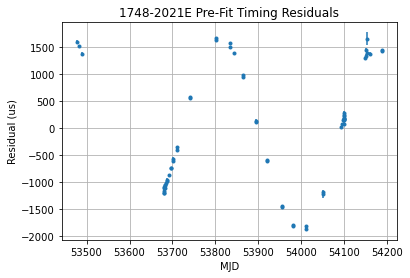

In [10]:
plt.errorbar(
    toas.get_mjds().value,
    f.resids_init.time_resids.to_value(u.us),
    yerr=toas.get_errors().to_value(u.us),
    fmt=".",
)
plt.title("%s Pre-Fit Timing Residuals" % model.PSR.value)
plt.xlabel("MJD")
plt.ylabel("Residual (us)")
plt.grid()

### Fit the TOAs using `P0` and `P1`

In [11]:
f.fit_toas()

/home/luo/.local/lib/python3.6/site-packages/pint/models/timing_model.py:304: UserWarning: PINT only supports 'T2CMETHOD IAU2000B'
  warn("PINT only supports 'T2CMETHOD IAU2000B'")


59.57431916084274442

### Plot the post-fit residuals

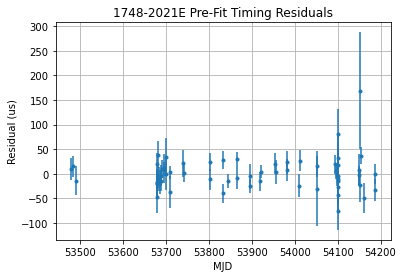

In [12]:
plt.errorbar(
    toas.get_mjds().value,
    f.resids.time_resids.to_value(u.us),
    yerr=toas.get_errors().to_value(u.us),
    fmt=".",
)
plt.title("%s Pre-Fit Timing Residuals" % model.PSR.value)
plt.xlabel("MJD")
plt.ylabel("Residual (us)")
plt.grid()

### Print out the summary

In [13]:
f.print_summary()

Fitted model using weighted_least_square method with 5 free parameters to 62 TOAs
Prefit residuals Wrms = 1090.5804716423524 us, Postfit residuals Wrms = 21.182038641716428 us
Chisq = 59.574 for 56 d.o.f. for reduced Chisq of 1.064

PAR                        Prefit                  Postfit            Units
=================== ==================== ============================ =====
PSR                           1748-2021E 1748-2021E                   None
EPHEM                              DE421 DE421                        None
CLOCK                          UTC(NIST) TT(BIPM2015)                 None
UNITS                                TDB TDB                          None
START                                                         53478.3 d 
FINISH                                                        54187.6 d 
TIMEEPH                             FB90 FB90                         None
T2CMETHOD                          TEMPO TEMPO                        None
DILATEFREQ         